### AJUSTE DO AMBIENTE E IMPORTAÇÃO DE BIBLIOTECAS A SEREM USADAS

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import re
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, adjusted_rand_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### WEB SCRAPPING DOS DADOS DIRETO DO SITE 'CRUZEIROPEDIA'

In [12]:
# faz a requisição HTTP para a página principal
response = requests.get('https://cruzeiropedia.org/Categoria:Temporadas')

# faz o parsing do HTML da página principal
soup = BeautifulSoup(response.content, 'html.parser')

In [13]:
# encontra todas as tags <a> que contêm o nome das temporadas (identifica os links) 
temporadas = soup.find_all('a', {'title': 
                                 ['Categoria:Temporada 2011',
                                  'Categoria:Temporada 2012',
                                  'Categoria:Temporada 2013',
                                  'Categoria:Temporada 2014',
                                  'Categoria:Temporada 2015',
                                  'Categoria:Temporada 2016',
                                  'Categoria:Temporada 2017', 
                                  'Categoria:Temporada 2018', 
                                  'Categoria:Temporada 2019', 
                                  'Categoria:Temporada 2020', 
                                  'Categoria:Temporada 2021', 
                                  'Categoria:Temporada 2022',
                                  'Categoria:Temporada 2023']
                                  }
                                  )

In [14]:
# lista para armazenar os dados encontrados
anos = []
diasSemanas = []
datas = []
adversarios = []
pubPagantes = []
pubPresentes = []
rendaBrutas = []
estadios = []
campeonatos = []
placares = []
horarios = []

# 'varre' a lista de temporadas especificada acima
for temporada in temporadas:
    # obtém o link da temporada
    link_temporada = temporada.get('href')
    
    # faz a requisição HTTP para a página da temporada
    response_temporada = requests.get('https://cruzeiropedia.org' + link_temporada)
    
    # faz o parsing do HTML da página da temporada
    soup_temporada = BeautifulSoup(response_temporada.content, 'html.parser')
    
    # identifica os jogos que o cruzeiro foi mandante na temporada em questão
    jogos = soup_temporada.find_all('a', {'title': re.compile(r'(.+) (\d+)x(\d+) (.+) - (\d{2}/\d{2}/\d{4})')})

    # entra em cada um dos jogos
    for jogo in jogos:
        # obtém o link do jogo
        link_jogos = jogo.get('href')

        if "Slovan" in link_jogos:
            continue

        elif "Tr%C3%ADplice" in link_jogos:
            continue
    
        # faz a requisição HTTP para a página do jogo
        response_jogos = requests.get('https://cruzeiropedia.org' + link_jogos)
        # faz o parsing do html da página do jogo
        soup_jogos = BeautifulSoup(response_jogos.content, 'html.parser')
        # retira a informação do dia da semana e horário
        diaSemana = soup_jogos.find('b', string='Data:').next_sibling.strip()
        diasSemanas.append(diaSemana)

        ano = soup_jogos.find('b', string='Data:').find_next_sibling().find_next_sibling().text.strip()
        anos.append(ano)

        data = soup_jogos.find('b', string='Data:').find_next_sibling().text.strip()
        datas.append(data)

        adversario = soup_jogos.find('b', string='Placar').find_next_sibling().find_next_sibling().find_next_sibling().text.strip()
        adversarios.append(adversario)

        pubPagante = soup_jogos.find('b', string='Público pagante:').next_sibling.strip()
        pubPagantes.append(pubPagante)

        pubPresente = soup_jogos.find('b', string='Público Presente:').next_sibling.strip()
        pubPresentes.append(pubPresente)

        rendaBruta = soup_jogos.find('b', string='Renda Bruta:').next_sibling.strip()
        rendaBrutas.append(rendaBruta)

        estadio = soup_jogos.find('b', string='Estádio:').find_next_sibling().text.strip()
        estadios.append(estadio)
        
        campeonato = soup_jogos.find('div', class_='divFichaSessao')
        campeonato_element = campeonato.find('b')
        campeonato_element_title = campeonato_element.text.strip()
        campeonatos.append(campeonato_element_title)

        placar_element = soup_jogos.find('div', class_='divFicha')
        placar = placar_element.find('b').text
        placares.append(placar)

        horario = soup_jogos.find('b', string='Data:').find_next_sibling().find_next_sibling().next_sibling.strip()
        horarios.append(horario)



### ESTRUTURAÇÃO DOS DADOS COLETADOS EM DATAFRAME + PRÉ-VISUALIZAÇÃO DOS DADOS

In [374]:
# ESTRUTURANDO OS DADOS CAPTURADOS EM UM DATAFRAME

df_raw = pd.DataFrame({'visitante':adversarios,
                       'ano': anos,
                       'dia da semana': diasSemanas,
                       'data': datas,
                       'publico presente': pubPresentes,
                       'publico pagante':pubPagantes,
                       'renda bruta': rendaBrutas,
                       'estadio':estadios,
                       'campeonato':campeonatos,
                       'placar':placares,
                       'horario':horarios})
df = df_raw.copy()

In [445]:
# Salvando em um excel para evitar de ter que rodar o web scrapping inteiro toda vez que for trabalhar 

df_raw.to_excel("C:\\Users\\Pichau\\Desktop\\datasets usados\\Dataset Cruzeiro\\Cruzeiro.xlsx", index=False)

In [5]:
# Análise da cauda final do df para ver se o script deu certo e se são os jogos mais recentes mesmo
df.tail(5)

,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario
819,Cruzeiro,2023,"quinta-feira,",2 de novembro,50.570,50.570,"R$ 3.115.984,00",Morumbi,31ª rodada do Campeonato Brasileiro 2023,1 × 0,às 20:00
820,Internacional,2023,"domingo,",5 de novembro,36.801,33.350 (14.524 sócios),"R$ 1.467.220,00",Mineirão,32ª rodada do Campeonato Brasileiro 2023,1 × 2,às 16:00
821,Cruzeiro,2023,"sábado,",11 de novembro,6.137,6.137,"R$ 181.620,00",Durval Britto,34ª rodada do Campeonato Brasileiro 2023,1 × 0,às 19:00
822,Cruzeiro,2023,"sábado,",18 de novembro,30.804,30.144,"R$ 328.787,00",Castelão-CE,30ª rodada do Campeonato Brasileiro 2023,0 × 1,às 18:30
823,Vasco,2023,"quarta-feira,",22 de novembro,0,0,"R$ 0,00",Mineirão,33ª rodada do Campeonato Brasileiro 2023,2 × 2,às 19:00


### FILTRANDO APENAS CAMPEONATO BRASILEIRO - AMOSTRA A SER TRABALHADA

In [6]:
# AJUSTANDO OS NOMES DOS CAMPEONATOS
camp_ajustado = []
for i in range(0,len(df)):
    if "Mineiro" in df['campeonato'][i]:
        camp_ajustado.append('Campeonato Mineiro')
    elif "Libertadores" in df['campeonato'][i]:
        camp_ajustado.append('Libertadores')
    elif "Amistoso" in df['campeonato'][i]:
        camp_ajustado.append('Amistoso')
    elif "Copa do Brasil" in df['campeonato'][i]:
        camp_ajustado.append('Copa do Brasil')
    elif "Brasileiro" in df['campeonato'][i]:
        camp_ajustado.append('Brasileirão')
    elif "Primeira Liga" in df['campeonato'][i]:
        camp_ajustado.append('Primeira Liga')
    elif "Sul-Americana" in df['campeonato'][i]:
        camp_ajustado.append('Sul-Americana')
    elif "Inconfidência" in df['campeonato'][i]:
        camp_ajustado.append('Inconfidência')
    elif "2ª rodada - 1ª fase da Copa Sul-Minas-Rio 2016" in df['campeonato'][i]:
        camp_ajustado.append('Copa Sul-Minas-Rio')
    else:
        camp_ajustado.append('nao')

df['camp_ajustado'] = camp_ajustado

In [7]:
# CONFERINDO OS NOMES DOS CAMPEONATOS - HÁ ERROS NOS AMISTOSOS
for i in df['camp_ajustado'].unique():
    display(df[df['camp_ajustado'] == i])

,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
0,Cruzeiro,2011,"domingo,",23 de janeiro,Não disponível,1.243,"R$ 12.820,00",Parque do Sabiá,Amistoso 2011,0 × 3,às 17:00,Amistoso
62,América-MG,2012,"domingo,",22 de janeiro,2.170,2.170,"R$ 22.475,00",Parque do Sabiá,Amistosos 2012,2 × 3,às 17:00,Amistoso
63,Cruzeiro,2012,"sábado,",28 de janeiro,12.000,10.000,Não informado,Arena do Sapo,Amistoso 2012,1 × 2,às 16:00,Amistoso
120,Cruzeiro,2013,"domingo,",27 de janeiro,Não disponível,5.000,Não informado,Arena do Sapo,Amistoso,1 × 4,às 17:00,Amistoso
144,Cruzeiro,2013,"domingo,",23 de junho,Não disponível,5.724,Não informado,Lockhart,Amistoso 2013,0 × 4,às 20:30,Amistoso
145,Cruzeiro,2013,"sábado,",29 de junho,Não disponível,2.500,Não informado,Toyota Park,Amistoso 2013,1 × 2,às 17:00,Amistoso
217,Cruzeiro,2014,"domingo,",22 de junho,Não disponível,5.000,Não informado,Bowditch Stadium,Amistosos 2014,1 × 5,às 16:00,Amistoso
218,Cruzeiro,2014,"terça-feira,",24 de junho,Não disponível,Não disponível,Não informado,Veterans Memorial Stadium,Amistoso 2014,1 × 2,às 20:30,Amistoso
219,Cruzeiro,2014,"sexta-feira,",27 de junho,Não disponível,Não disponível,Não informado,Cotton Bowl,Amistoso 2014,3 × 5,às 21:30,Amistoso
220,Cruzeiro,2014,"quinta-feira,",3 de julho,Não disponível,Não disponível,Não informado,BBVA Compass Stadium,Amistoso 2014,0 × 2,às 22:00,Amistoso


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
1,Caldense,2011,"domingo,",30 de janeiro,Não disponível,4.151,"R$ 82.980,00",Arena do Jacaré,1ª rodada do Campeonato Mineiro 2011,3 × 0,às 17:00,Campeonato Mineiro
2,Cruzeiro,2011,"domingo,",6 de fevereiro,Não disponível,4.144,"R$ 55.230,00",Castor Cifuentes,2ª rodada do Campeonato Mineiro 2011,0 × 1,às 19:30,Campeonato Mineiro
3,Atlético-MG,2011,"sábado,",12 de fevereiro,Não disponível,9.793,"R$ 267.256,88",Arena do Jacaré,3º rodada do Campeonato Mineiro 2011,3 × 4,às 19:30,Campeonato Mineiro
5,Ipatinga,2011,"sábado,",19 de fevereiro,2.045,1.664,"R$ 25.108,13",Arena do Jacaré,4ª rodada do Campeonato Mineiro 2011,2 × 0,às 17:00,Campeonato Mineiro
7,Cruzeiro,2011,"sábado,",26 de fevereiro,Não disponível,5.000,"R$ 111.350,00",Arena do Dragão,5ª rodada da Campeonato Mineiro 2011,1 × 2,às 16:00,Campeonato Mineiro
...,...,...,...,...,...,...,...,...,...,...,...,...
780,Cruzeiro,2023,"sábado,",18 de fevereiro,3.245,2.745,"R$ 100.350,00",Castor Cifuentes,6ª rodada do Campeonato Mineiro 2023,0 × 4,às 19:30,Campeonato Mineiro
781,Cruzeiro,2023,"quinta-feira,",23 de fevereiro,2.790,1.982,"R$ 76.825,00",Ronaldão,7ª rodada do Campeonato Mineiro 2023,1 × 2,às 19;30,Campeonato Mineiro
782,Democrata-SL,2023,"sábado,",4 de março,6.589,4.588 (658 sócios),"R$ 405.888,00",Kléber Andrade,8ª rodada do Campeonato Mineiro 2023,1 × 1,às 16:30,Campeonato Mineiro
783,América-MG,2023,"sábado,",11 de março,19.227,17.500 (1.512 sócios),"R$ 625.347,50",Arena do Jacaré,Jogo de ida - Semi-Final do Campeonato Mineiro...,0 × 2,às 16:30,Campeonato Mineiro


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
4,Estudiantes,2011,"quarta-feira,",16 de fevereiro,Não disponível,10.955,"R$ 377.267,50",Arena do Jacaré,1ª Rodada - Fase de Grupos da Copa Libertadore...,5 × 0,às 22:00,Libertadores
6,Guarani-PAR,2011,"terça-feira,",22 de fevereiro,13.271,12.067,"R$ 275.668,02",Arena do Jacaré,2ª rodada - Fase de Grupos da Copa Libertadore...,4 × 0,às 19:15,Libertadores
8,Cruzeiro,2011,"quarta-feira,",2 de março,Não disponível,Não disponível,Não informado,Manuel Toro,3ª rodada - Fase de Grupos da Copa Libertadore...,0 × 0,às 19:30,Libertadores
11,Tolima,2011,"quarta-feira,",16 de março,Não disponível,8.198,"R$ 187.000,00",Arena do Jacaré,4ª rodada - Fase de Grupos da Copa Libertadore...,6 × 1,às 21:50,Libertadores
14,Cruzeiro,2011,"quarta-feira,",30 de março,Não disponível,Não disponível,Não informado,Defensores del Chaco,5ª rodada - Fase de Grupo da Copa Libertadores...,0 × 2,às 22:00,Libertadores
16,Cruzeiro,2011,"quarta-feira,",13 de abril,Não disponível,Não disponível,Não informado,Ciudad de La Plata,6ª rodada - Fase de Grupos da Copa Libertadore...,0 × 3,às 21:50,Libertadores
17,Cruzeiro,2011,"quarta-feira,",27 de abril,Não disponível,Não disponível,Não informado,Palo Grande,Jogo de ida - Oitavas de final da Copa Liberta...,1 × 2,às 21:50,Libertadores
21,Once Caldas,2011,"quarta-feira,",4 de maio,15.962,14.972,"R$ 352.780,39",Arena do Jacaré,Jogo de volta - Oitavas de final da Copa Liber...,0 × 2,às 21:50,Libertadores
187,Cruzeiro,2014,"quarta-feira,",12 de fevereiro,Não disponível,Não disponível,Não informado,Huancayo,1ª rodada - Fase de Grupos da Copa Libertadore...,2 × 1,às 22:00,Libertadores
191,Universidad de Chile,2014,"terça-feira,",25 de fevereiro,29.120,27.757,"R$ 957.725,00",Mineirão,2ª rodada - Fase de Grupos da Copa Libertadore...,5 × 1,às 17:30,Libertadores


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
24,Cruzeiro,2011,"domingo,",22 de maio,Não disponível,10.231,"R$ 120.670,00",Orlando Scarpelli,1ª rodada do Campeonato Brasileiro 2011,1 × 0,às 16:00,Brasileirão
25,Palmeiras,2011,"domingo,",29 de maio,Não disponível,9.080 (865 sócios),"R$ 147.838,25",Arena do Jacaré,2ª rodada do Campeonato Brasileiro 2011,1 × 1,às 16:00,Brasileirão
26,Cruzeiro,2011,"domingo,",5 de junho,Não disponível,4.530,"R$ 131.365,00",Engenhão,3ª rodada do Campeonato Brasileiro 2011,2 × 1,às 16:00,Brasileirão
27,Santos,2011,"sábado,",11 de junho,7.133,6.073 (668 sócios),"R$ 104.820,00",Arena do Jacaré,4ª rodada do Campeonato Brasileiro 2011,1 × 1,às 18:30,Brasileirão
28,Cruzeiro,2011,"sábado,",18 de junho,5.627,5.027,"R$ 87.145,00",Arena do Jacaré,5ª rodada do Campeonato Brasileiro 2011,1 × 1,às 21:00,Brasileirão
...,...,...,...,...,...,...,...,...,...,...,...,...
819,Cruzeiro,2023,"quinta-feira,",2 de novembro,50.570,50.570,"R$ 3.115.984,00",Morumbi,31ª rodada do Campeonato Brasileiro 2023,1 × 0,às 20:00,Brasileirão
820,Internacional,2023,"domingo,",5 de novembro,36.801,33.350 (14.524 sócios),"R$ 1.467.220,00",Mineirão,32ª rodada do Campeonato Brasileiro 2023,1 × 2,às 16:00,Brasileirão
821,Cruzeiro,2023,"sábado,",11 de novembro,6.137,6.137,"R$ 181.620,00",Durval Britto,34ª rodada do Campeonato Brasileiro 2023,1 × 0,às 19:00,Brasileirão
822,Cruzeiro,2023,"sábado,",18 de novembro,30.804,30.144,"R$ 328.787,00",Castelão-CE,30ª rodada do Campeonato Brasileiro 2023,0 × 1,às 18:30,Brasileirão


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
69,Cruzeiro,2012,"quarta-feira,",7 de março,Não disponível,5.174,"R$ 113.420,00",Arena da Floresta,1ª fase - Copa do Brasil 2012,0 × 6,às 22:00,Copa do Brasil
75,Cruzeiro,2012,"quarta-feira,",11 de abril,Não disponível,7.085,"R$ 102.760,00",Arena Condá,Jogo de ida - 2ª fase da Copa do Brasil 2012,1 × 1,às 22:00,Copa do Brasil
77,Chapecoense,2012,"quarta-feira,",18 de abril,5.311,4.078,"R$ 66.990,00",Arena do Jacaré,Jogo de volta - 2ª fase da Copa do Brasil 2012,4 × 1,às 21:50,Copa do Brasil
80,Cruzeiro,2012,"quarta-feira,",2 de maio,Não disponível,6.581,"R$ 92.360,00",Durival de Britto,Jogo de ida - Oitavas de Final da Copa do Bras...,1 × 0,às 21:50,Copa do Brasil
81,Atlético-PR,2012,"quarta-feira,",9 de maio,Não disponível,8.769,"R$ 156.707,00",Arena do Jacaré,Jogo de volta - Oitavas de final da Copa do Br...,1 × 2,às 22:00,Copa do Brasil
...,...,...,...,...,...,...,...,...,...,...,...,...
753,Fluminense,2022,"terça-feira,",12 de julho,58.844,52.799 (2.703 sócios),"R$ 2.674.320,00",Mineirão,Jogo de volta - Oitavas de final da Copa do Br...,0 × 3,às 21:00,Copa do Brasil
786,Cruzeiro,2023,"quinta-feira,",13 de abril,6.435,4.523,"R$ 132.246,50",Aflitos,Jogo de ida - 3ª fase da Copa do Brasil 2023,1 × 0,às 19:00,Copa do Brasil
789,Náutico,2023,"terça-feira,",25 de abril,21.657,19.489 (1.396 sócios),"R$ 554.127,00",Independência,Jogo de volta - 3ª fase da Copa do Brasil 2023,2 × 0,às 19:00,Copa do Brasil
794,Cruzeiro,2023,"quarta-feira,",17 de maio,27.522,27.522,"R$ 1.584.033,00",Arena Grêmio,Jogo de ida - Oitavas de final da Copa do Bras...,1 × 1,às 19:30,Copa do Brasil


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
393,Atlético-MG,2017,"quarta-feira,",1 de fevereiro,41.430,39.794 (13.444 sócios),"R$ 1.139.052,00",Mineirão,1ª rodada - 1ª fase da Copa Primeira Liga 2017,1 × 0,às 19:30,Primeira Liga
395,Chapecoense,2017,"quinta-feira,",9 de fevereiro,7.057,4.823,"R$ 98.177,00",Mineirão,2ª rodada da Copa Primeira Liga 2017,2 × 0,às 21:45,Primeira Liga
406,Cruzeiro,2017,"terça-feira,",21 de março,Não disponível,2.238,"R$ 20.100,00",Arena Joinville,3ª rodada - 1ª fase da Copa Primeira Liga 2017,0 × 0,às 19:00,Primeira Liga
446,Grêmio,2017,"quarta-feira,",30 de agosto,7.545,5.680,"R$ 69.343,00",Mineirão,Quartas de final - Jogo único da Copa Primeira...,2 × 0,às 21:45,Primeira Liga
447,Cruzeiro,2017,"domingo,",3 de setembro,17.061,15.420,"R$ 150.183,00",Estádio do Café,Jogo único - Semi-Final da Copa Primeira Liga ...,2 × 2,às 11:00,Primeira Liga


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
409,Nacional-PAR,2017,"terça-feira,",4 de abril,16.784,13.747,"R$ 247.108,00",Mineirão,Jogo de ida - 1ª fase da Copa Sul-Americana 2017,2 × 1,às 21:45,Sul-Americana
418,Cruzeiro,2017,"quarta-feira,",10 de maio,Não disponível,Não disponível,Não informado,Defensores del Chaco,Jogo da volta - 1ª fase da Copa Sul-Americana ...,2 × 1,às 19:15,Sul-Americana


,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario,camp_ajustado
622,Patrocinense,2020,"sábado,",1 de agosto,0,0,"R$ 0,00",Mineirão,Jogo único - Semifinal do Troféu Inconfidência...,3 × 0,às 14:30,Inconfidência


In [8]:
# AJUSTANDO MANUALMENTE OS ERROS NOS AMISTOSOS
df.loc[159, 'camp_ajustado'] = 'Copa-Sul-Minas-Rio'
df.loc[161, 'camp_ajustado'] = 'Copa-Sul-Minas-Rio'

In [9]:
# FILTRANDO APENAS BRASILEIRAO
df = df[df['camp_ajustado'] == "Brasileirão"].reset_index(drop='index')

### DATA WRANGLING

In [10]:
# RETIRADA DA VÍRGULA NO FINAL DO DIA DA SEMANA
df['dia da semana'] = df['dia da semana'].str[:-1]

# SEPARAÇÃO DA COLUNA DATA EM DIA E MÊS
df[['dia do mes', 'mes']] = df['data'].str.split(' de ', expand= True)

# RETIRADA DO R$ NO RENDA BRUTA
df['renda bruta'] = df['renda bruta'].str.slice(start=2)

#RETIRADA DOS PARÊNTESES COM AS INFOS DOS SÓCIOS DO PUB PAGANTE 
df[['publico pagante','erro1','erro2']] = df['publico pagante'].str.split(' ',expand=True)

# AJUSTE DA COLUNA DE HORÁRIO - RETIRADA DA STRING ÀS E DOS :/;
df['horario'] = df['horario'].str.slice(start=3)
df['horario'] = df['horario'].str.replace(';',':')
df['horario'] = df['horario'].str.replace(':','')

#RETIRANDO AS COLUNAS CRIADAS APENAS PARA RETIRADA DOS SÓCIOS
df.drop(columns=['erro1','erro2'],inplace=True)

# CONSERTANDO OS SEPARADORES NÚMERICOS (, E .) DAS COLUNAS NUMÉRICAS
for i in range(0,len(df)):
    df['renda bruta'][i] = df['renda bruta'][i].replace('.','')
    df['renda bruta'][i] = df['renda bruta'][i].replace(',','.')
    df['publico presente'][i] = df['publico presente'][i].replace('.','')
    df['publico pagante'][i] = df['publico pagante'][i].replace('.','')

# AJUSTANDO A COLUNA DE PLACAR E CRIANDO UMA NOVA PARA ANLALISAR VITÓRIA
df[['golsMandante','golsVisitante']] = df['placar'].str.split(' × ',expand=True)
df['pontosAlcancados'] = None
for i in range(0,len(df)):
    if df['golsMandante'][i] == df['golsVisitante'][i]:
        df['pontosAlcancados'][i] = 1

    elif df['golsMandante'][i] > df['golsVisitante'][i] and df['visitante'][i] == 'Cruzeiro':
        df['pontosAlcancados'][i] = 0

    elif df['golsMandante'][i] > df['golsVisitante'][i] and df['visitante'][i] != 'Cruzeiro':
        df['pontosAlcancados'][i] = 3

    elif df['golsMandante'][i] < df['golsVisitante'][i] and df['visitante'][i] == 'Cruzeiro':
        df['pontosAlcancados'][i] = 3

    elif df['golsMandante'][i] < df['golsVisitante'][i] and df['visitante'][i] != 'Cruzeiro':
        df['pontosAlcancados'][i] = 0

# CRIANDO UMA NOVA COLUNA COM O RESULTADO DO JOGO
df['resultado'] = None
for i in range(0,len(df)):
    if df['pontosAlcancados'][i] == 0:
        df['resultado'][i] = "Derrota"
    elif df['pontosAlcancados'][i] == 1:
        df['resultado'][i] = "Empate"
    elif df['pontosAlcancados'][i] == 3:
        df['resultado'][i] = "Vitoria"
    else:
        df['resultado'][i] = "Erro"

# CRIANDO NOVA COLUNA DE APROVEITAMENTO

df['aproveitamento_geral_previo'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['aproveitamento_geral_previo'][i] = 0        
    elif df['ano'][i] != df['ano'][i-1]:
        df['aproveitamento_geral_previo'][i] = 0
    else:
        df['aproveitamento_geral_previo'][i] = df[df['pontosAlcancados'].index < i]['pontosAlcancados'].sum()/(i*3)

# CRIANDO COLUNA DE JOGOS DE INVENCIBILIDADE

df['sequencia_invencibilidade_temp'] = None
qtd_invencibilidade = 0
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['sequencia_invencibilidade_temp'][i] = 0
    elif df['ano'][i] != df['ano'][i-1]:
        df['sequencia_invencibilidade_temp'][i] = 0
    elif df['resultado'][i] == "Vitoria" or df['resultado'][i] == "Empate":
        qtd_invencibilidade +=1 
        df['sequencia_invencibilidade_temp'][i] = qtd_invencibilidade
    else:
        qtd_invencibilidade = 0
        df['sequencia_invencibilidade_temp'][i] = qtd_invencibilidade

df['sequencia_invencibilidade_previa'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['sequencia_invencibilidade_previa'][i] = 0
    elif df['ano'][i] != df['ano'][i-1]:
        df['sequencia_invencibilidade_previa'][i] = 0
    else:
        df['sequencia_invencibilidade_previa'][i] = df['sequencia_invencibilidade_temp'][i-1]

df.drop('sequencia_invencibilidade_temp', axis=1, inplace=True)

# CRINDO UMA VARIÁVEL DUMMY INDICANDO SE TRATA DO PRIMEIRO JOGO DA TEMPORADA
df['estreia'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['estreia'][i] = 1
    elif df['ano'][i] != df['ano'][i-1]:
        df['estreia'][i] = 1
    else:
        df['estreia'][i] = 0

# CRINDO UMA VARIÁVEL DUMMY INDICANDO SE É CLASSICO
df['classico'] = None
for i,v in enumerate(range(0,len(df))):
    if df['visitante'][i] == "Atlético-MG":
        df['classico'][i] = 1
    else:
        df['classico'][i] = 0

### DATA CLEANING

In [11]:
# CONFERINDO LINHAS DUPLICADAS
df.duplicated().sum()

0

In [12]:
# CONFERINDO LINHAS NULAS
df.isnull().sum()

visitante                           0
ano                                 0
dia da semana                       0
data                                0
publico presente                    0
publico pagante                     0
renda bruta                         0
estadio                             0
campeonato                          0
placar                              0
horario                             0
camp_ajustado                       0
dia do mes                          0
mes                                 0
golsMandante                        0
golsVisitante                       0
pontosAlcancados                    0
resultado                           0
aproveitamento_geral_previo         0
sequencia_invencibilidade_previa    0
estreia                             0
classico                            0
dtype: int64

In [13]:
# CONFERINDO FORMATOS DE ESCRITA DISTINTOS NA COLUNA DE HORARIO
df['horario'].unique()

array(['1600', '1830', '2100', '1930', '2200', '1800', '2030', '2150',
       '1700', '1900', '1620', '15h', '1100', '2145', '2000', '1630',
       '1915', '2130', '2015', '1815', '190', '19h', '16h'], dtype=object)

In [14]:
# FORMATANDO CADA UM DOS REGISTROS INCOERENTES
for i,v in enumerate(df['horario']):
    if v == '190' or v == '19h':
        df['horario'][i] = '1900'
    if v == '16h':
        df['horario'][i] = '1600'
    if v == '15h':
        df['horario'][i] = '1500'
    else:
        continue

In [15]:
# NOVOS VALORES DE HORARIOS
df['horario'].unique()

array(['1600', '1830', '2100', '1930', '2200', '1800', '2030', '2150',
       '1700', '1900', '1620', '1500', '1100', '2145', '2000', '1630',
       '1915', '2130', '2015', '1815'], dtype=object)

In [16]:
df['estadio'] = df['estadio'].replace('Arena Buser','Arena do Jacaré')

EXPLICAÇÃO DO REMOÇÃO DE ALGUMAS COLUNAS 

>>PUBLICO PRESENTE -> dados muito poluídos, com alguns registros de "não disponível".  
>>CAMPEONATO e CAMP_AJUSTADO -> como trata-se apenas de brasileirão não faz sentido mantê-las  
>>PLACAR -> a coluna placar foi segregada entre as colunas de golsCruzeiro e golsAdversario  
>>DATA -> coluna foi desmembrada e não faz mais sentido mantê-la  
>>ANO -> usada apenas como regra para novas variáveis. Sem usabilidade e sem sentido  
>>golsMandante, golsVisitante, pontosAlcancados e resultados -> informações usadas apenas para criar regras de novas colunas criadas. São informações que não são conhecidas no momento da predição e por isso não servem como variáveis x  
>>RENDA BRUTA -> vazaria dados. 

In [17]:
# RETIRANDO COLUNAS NÃO UTILIZADAS

colunas_excluidas = ['publico presente','placar','data','campeonato','camp_ajustado','golsMandante','golsVisitante','pontosAlcancados','resultado','renda bruta']

df = df.drop(columns=colunas_excluidas)

### DATA PREPARATION

In [18]:
# MANTENDO APENAS OS REGISTROS DO CRUZEIRO COMO MANDANTE
df = df[df['visitante'] != "Cruzeiro"].reset_index(drop='index')

In [19]:
# ALTERANDO OS NOMES DOS MESES PARA NÚMEROS
meses_para_numeros ={
                     'janeiro': 1,
                     'fevereiro': 2,
                     'março': 3,
                     'abril': 4,
                     'maio': 5,
                     'junho': 6,
                     'julho': 7,
                     'agosto': 8,
                     'setembro': 9,
                     'outubro': 10,
                     'novembro': 11,
                     'dezembro': 12
                    }

df['mes'] = df['mes'].map(meses_para_numeros)

In [20]:
# CONFERINDO TIPO DE DADOS PARA MANUTENÇÃO
df.dtypes

visitante                           object
ano                                  int64
dia da semana                       object
publico pagante                     object
estadio                             object
horario                             object
dia do mes                          object
mes                                  int64
aproveitamento_geral_previo         object
sequencia_invencibilidade_previa    object
estreia                             object
classico                            object
dtype: object

In [21]:
# ALTERANDO O TIPO DE DADOS DE CADA COLUNA UMA A UMA PARA FACILITAR A IDENTIFICAÇÃO

df['visitante'] = df['visitante'].astype('category')                         
df['dia da semana'] = df['dia da semana'].astype('category')                                                  
df['publico pagante']= df['publico pagante'].astype('float')                               
df['estadio'] = df['estadio'].astype('category')                                                             
df['dia do mes'] = df['dia do mes'].astype(int)                   
df['mes'] = df['mes'].astype(int)
df['ano'] = df['ano'].astype(int)                                                           
df['aproveitamento_geral_previo'] = df['aproveitamento_geral_previo'].astype('float')               
df['sequencia_invencibilidade_previa'] = df['sequencia_invencibilidade_previa'].astype(int)    
df['estreia'] = df['estreia'].astype(int)
df['classico'] = df['classico'].astype(int)
df['horario'] = df['horario'].astype(int)

In [22]:
# NOVOS TIPOS DE DADOS
df.dtypes

visitante                           category
ano                                    int32
dia da semana                       category
publico pagante                      float64
estadio                             category
horario                                int32
dia do mes                             int32
mes                                    int32
aproveitamento_geral_previo          float64
sequencia_invencibilidade_previa       int32
estreia                                int32
classico                               int32
dtype: object

In [23]:
df.tail()

,visitante,ano,dia da semana,publico pagante,estadio,horario,dia do mes,mes,aproveitamento_geral_previo,sequencia_invencibilidade_previa,estreia,classico
240,América-MG,2023,domingo,41386.0,Mineirão,1600,1,10,0.492693,0,0,0
241,Flamengo,2023,quinta-feira,32647.0,Mineirão,1900,19,10,0.492030,2,0,0
242,Bahia,2023,quarta-feira,33303.0,Mineirão,2000,25,10,0.492063,1,0,0
243,Internacional,2023,domingo,33350.0,Mineirão,1600,5,11,0.492096,0,0,0
244,Vasco,2023,quarta-feira,0.0,Mineirão,1900,22,11,0.491120,1,0,0


### CRIAÇÃO E AVALIAÇÃO DOS MODELOS

In [24]:
df[df['publico pagante'] != '0']

,visitante,ano,dia da semana,publico pagante,estadio,horario,dia do mes,mes,aproveitamento_geral_previo,sequencia_invencibilidade_previa,estreia,classico
0,Palmeiras,2011,domingo,9080.0,Arena do Jacaré,1600,29,5,0.000000,0,0,0
1,Santos,2011,sábado,6073.0,Arena do Jacaré,1830,11,6,0.111111,0,0,0
2,Coritiba,2011,sábado,5252.0,Arena do Jacaré,2100,25,6,0.200000,2,0,0
3,Grêmio,2011,quarta-feira,10652.0,Arena do Jacaré,1930,6,7,0.428571,4,0,0
4,Bahia,2011,domingo,6666.0,Arena do Jacaré,1830,17,7,0.444444,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
240,América-MG,2023,domingo,41386.0,Mineirão,1600,1,10,0.492693,0,0,0
241,Flamengo,2023,quinta-feira,32647.0,Mineirão,1900,19,10,0.492030,2,0,0
242,Bahia,2023,quarta-feira,33303.0,Mineirão,2000,25,10,0.492063,1,0,0
243,Internacional,2023,domingo,33350.0,Mineirão,1600,5,11,0.492096,0,0,0


In [25]:
# RETIRADA DE ALGUMAS FEATURES QUE ESTAVAM PIORANDO A PERFORMANCE DO MODELO
df_predict = df.drop(['visitante','estreia','dia do mes'],axis=1)
teste = pd.get_dummies(df_predict)

In [26]:
# SEPARAÇÃO DA VARIÁVEL TARGET E VARIÁVEIS PREDITORAS
y = teste['publico pagante']
X = teste.drop('publico pagante',axis=1)

In [27]:
# SPLIT DOS DADOS EM BASE DE TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# TREINAMENTO DO MODELO XGBOOST
xgb = XGBRegressor(n_estimators = 400, max_depth=25, random_state=200).fit(X_train,y_train)

# PREDIÇÃO DO MODELO XGBOOST
yxgb = xgb.predict(X_test)

# MÉTRICAS DO MODELO XGBOOST
mae_xgb = mean_absolute_error(y_test,yxgb)
mse_xgb = mean_squared_error(y_test,yxgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test,yxgb)
adj_r2_xgb = 1-(1-r2_xgb)*(len(df)-1)/(len(df)-len(df.columns)-1)

# TREINAMENTO DO MODELO RANDOM FOREST
rf = RandomForestRegressor(n_estimators= 600, max_depth=25, random_state=200).fit(X_train,y_train)

# PREDIÇÃO DO MODELO RANDOM FOREST
yrf = rf.predict(X_test)

# MÉTRICAS DO MODELO RANDOM FOREST
mae_rf = mean_absolute_error(y_test,yrf)
mse_rf = mean_squared_error(y_test,yrf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test,yrf)
adj_r2_rf = 1-(1-r2_rf)*(len(df)-1)/(len(df)-len(df.columns)-1)

# PRINT DAS MÉTRICAS ALCANÇADAS POR CADA MODELO
print('--------MÉTRICAS XGBOOST--------')
print(f'mae: {mae_xgb}\nmse: {mse_xgb}\nrmse: {rmse_xgb}\nr2: {r2_xgb}\nr2 ajustado: {adj_r2_xgb}')
print('')
print('-----MÉTRICAS RANDOM FOREST-----')
print(f'mae: {mae_rf}\nmse: {mse_rf}\nrmse: {rmse_rf}\nr2: {r2_rf}\nr2 ajustado: {adj_r2_rf}')

--------MÉTRICAS XGBOOST--------
mae: 5000.379637692426
mse: 53117983.269019954
rmse: 7288.2085088874865
r2: 0.7211064476893858
r2 ajustado: 0.7066809191215955

-----MÉTRICAS RANDOM FOREST-----
mae: 5430.454076576577
mse: 56231335.223379694
rmse: 7498.755578319625
r2: 0.7047599350263005
r2 ajustado: 0.6894888971828332


--------MÉTRICAS XGBOOST--------
mae: 5000.383739471436
mse: 53118017.14242492
rmse: 7288.210832736998
r2: 0.7211062698386155
r2 ajustado: 0.7066807320716473

-----MÉTRICAS RANDOM FOREST-----
mae: 5470.058130630631
mse: 57032240.86247751
rmse: 7551.969336701355
r2: 0.7005548164392049
r2 ajustado: 0.6850662724619224

In [28]:
# TIRANDO A MÉDIA DAS PREDIÇÕES DE CADA UM DOS MODELOS PARA VER SE O RESULTADO MELHORA (TEOREMA DAS MULTIDÕES)

ada = AdaBoostRegressor(n_estimators= 600, random_state=200).fit(X_train,y_train)
yada = ada.predict(X_test)

grad = GradientBoostingRegressor(n_estimators= 600,random_state=200).fit(X_train,y_train)
ygrad = grad.predict(X_test)

ymisto = (yrf + yxgb)/2

mae_misto = mean_absolute_error(y_test,ymisto)
mse_misto = mean_squared_error(y_test,ymisto)
rmse_misto = np.sqrt(mse_misto)
r2_misto = r2_score(y_test,ymisto)
adj_r2_misto = 1-(1-r2_misto)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('-----MÉTRICAS MISTO-----')
print(f'mae: {mae_misto}\nmse: {mse_misto}\nrmse: {rmse_misto}\nr2: {r2_misto}\nr2 ajustado: {adj_r2_misto}')


-----MÉTRICAS MISTO-----
mae: 4928.223582746833
mse: 48704912.478047505
rmse: 6978.890490475367
r2: 0.7442770749185702
r2 ajustado: 0.7310500270695308


-----MÉTRICAS MISTO-----
mae: 4948.776414182509
mse: 49064547.53012113
rmse: 7004.609020503652
r2: 0.7423888274544251
r2 ajustado: 0.7290641116331023

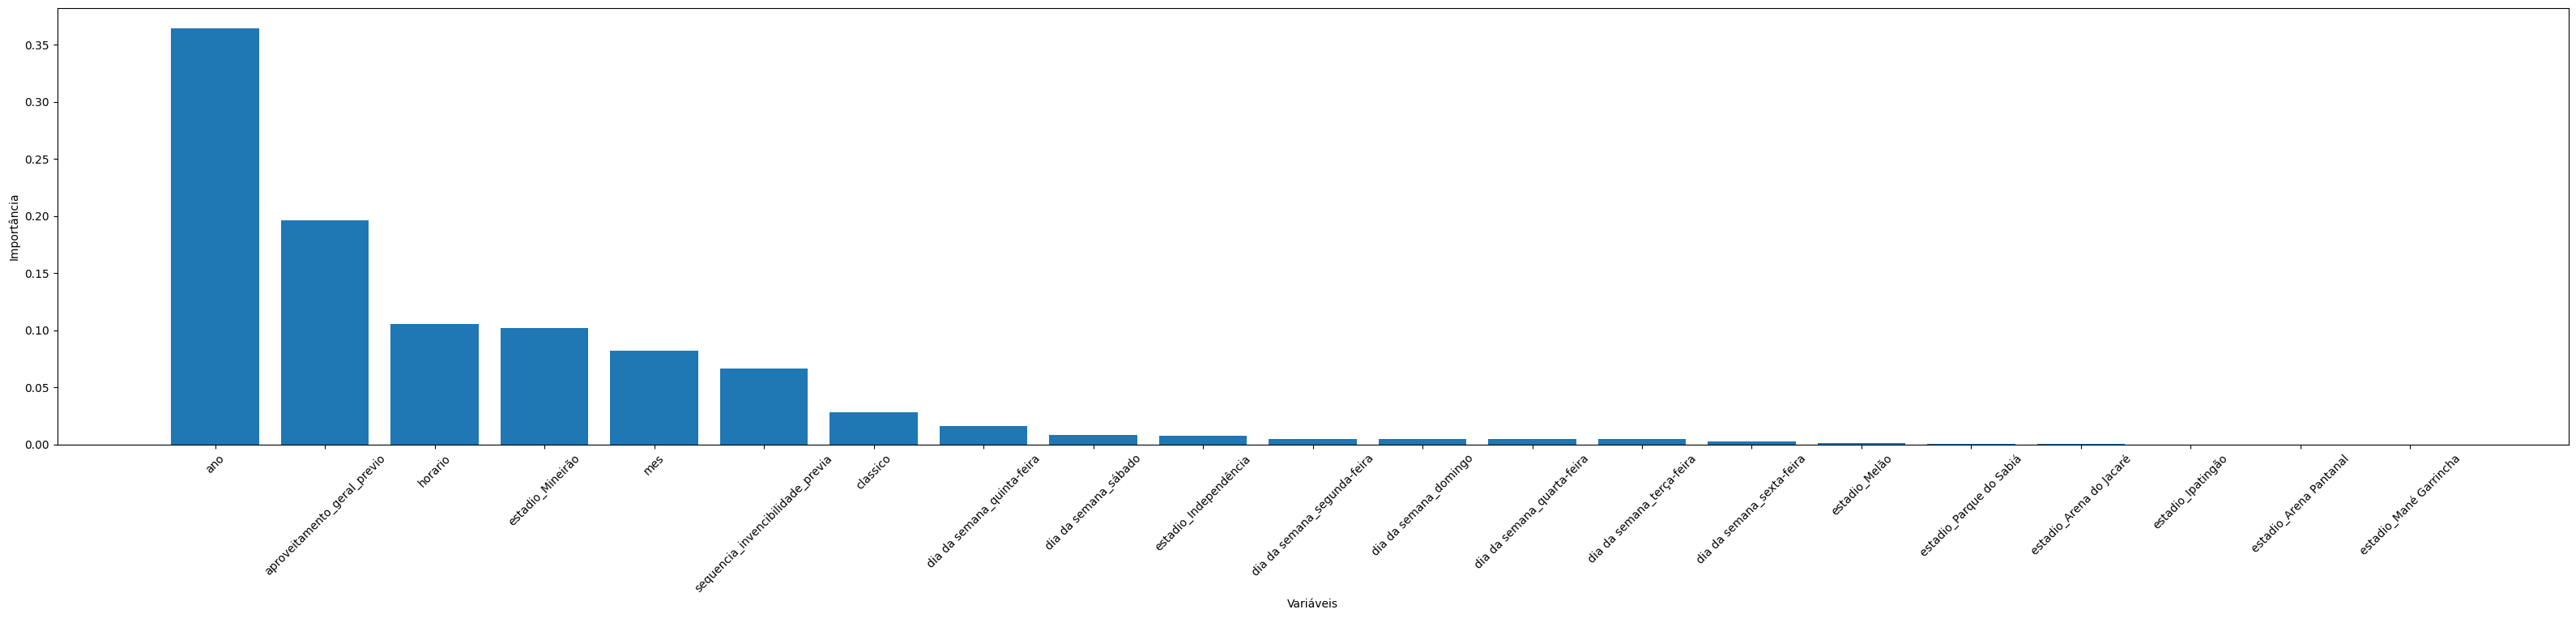

In [29]:
# Obtenha a importância das variáveis
importances = rf.feature_importances_

# Obtenha os nomes das variáveis
feature_names = X_test.columns  # Substitua pelo nome das suas variáveis

# Ordene as importâncias em ordem decrescente
indices = np.argsort(importances)[::-1]

# Plote as importâncias das variáveis em um gráfico de barras
plt.figure(figsize=(40, 7))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Variáveis")
plt.ylabel("Importância")
plt.show()

### PREDIÇÃO JOGO DO VASCO - CAP - PALMEIRAS 

In [45]:
# Predição do público do jogo do vasco caso tivesse torcida

vasco = np.array([2023,1900,11,0.491120,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False])

vasco = vasco.reshape(1,-1)

yvasco = xgb.predict(vasco)
yvasco2 = rf.predict(vasco)

(yvasco + yvasco2)/2

array([33459.9], dtype=float32)